# Описание проекта

Колонки в `telecom_dataset.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

# Шаг 1

## Откроем таблицу и изучим общую информацию о данных

In [1]:
# загружаем все нужные библиотеки

import pandas as pd
import datetime as dt
import math as mth
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
import numpy as np
from datetime import datetime, timezone

In [2]:
try:
    data_clients = pd.read_csv('/datasets/telecom_clients.csv') # таблица с колл-центрами и их тарифными планами
    data = pd.read_csv('/datasets/telecom_dataset.csv') # основная рабочая таблица с нужными данными для анализа
except:
    data_clients = pd.read_csv('C://Users//79231//Downloads//telecom_clients.csv')
    data = pd.read_csv('C://Users//79231//Downloads//telecom_dataset.csv')
    
display(data_clients.head())
data.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [4]:
data.duplicated(keep=False).sum() # посчитаем количество дубликатов. 
                                  #Выводим keep=False, чтобы вывести все дубликаты по каждому колл-центру

9800

In [5]:
data[data.duplicated(keep=False)] # выведем строки-дубликаты

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
38,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
...,...,...,...,...,...,...,...,...,...
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53883,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


У нас есть 53902 данных о работе операторов. Из них в столбце operator_id есть 8172 пропуска (это 15% от общего кол-ва данных) и в internal есть 117 пропусков (это 0.2%), также 4900 строк-дубликатов. Также столбцы date и operator_id имеют не походящие типы, нужно будет их изменить в дальнейшем.

# Шаг 2. Предобработка данных

## Приведем столбец date к нужному типу данных

In [6]:
data['date'] = pd.to_datetime(data['date']) # у нас осталась тайм-зона
data['date'] = data['date'].dt.date # оставим только дату
data['date'] = pd.to_datetime(data['date']) # вернем формат datetime
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


None

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


## Обработаем пропуски в столбце operator_id и internal

In [7]:
data_p = data[data['operator_id'].isna()] # выведем строки с пропущенными значениями
data_p.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34


У нас 15% пропусков. Это много, особенно учитывая то, что они находятся в главной для нас колонке, по которой мы будем определять id оператора. Удалить мы их просто так не можем, надо их обработать.

Мы видим, что у нас пропущены значения по разным колл-центрам, однако обработаем таких операторов отдельно. Присвоим всем пропускам значение '-1'.

In [8]:
data['operator_id'] = np.where(data['operator_id'].isnull(), '-1',data['operator_id'])
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,-1,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


In [9]:
# приведем столбец operator_id к целочисленному типу

data['operator_id'] = data['operator_id'].convert_dtypes()
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  datetime64[ns]
 2   direction            53902 non-null  object        
 3   internal             53785 non-null  object        
 4   operator_id          53902 non-null  string        
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(2), string(1)
memory usage: 3.3+ MB


None

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,-1,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


In [10]:
data[data['internal'].isna()] # выведем строки с пропущенными значениями

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18,in,NaN,-1,True,1,0,59
1090,166405,2019-10-01,in,NaN,-1,True,1,0,1
1864,166406,2019-08-20,in,NaN,-1,True,1,0,36
1924,166406,2019-09-02,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09,in,NaN,-1,True,6,0,14
52590,168361,2019-11-13,in,NaN,-1,True,2,0,6
52621,168361,2019-11-14,in,NaN,-1,True,1,0,2
53717,168579,2019-11-09,in,NaN,-1,True,1,0,18


Строк с пропущенными значениями внутренней линии у нас всего 117 штук, это 0.2% от общего количества данных.
Удалим их.

In [11]:
data = data.dropna()

## Обработаем\удалим дубликаты

In [12]:
data[data.duplicated(keep=False)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05,out,False,880020.0,True,8,0,50
8,166377,2019-08-05,out,False,880020.0,True,8,0,50
27,166377,2019-08-12,in,False,-1,True,2,0,34
28,166377,2019-08-12,in,False,-1,True,2,0,34
38,166377,2019-08-14,in,False,-1,True,1,0,3
...,...,...,...,...,...,...,...,...,...
53875,168601,2019-11-26,in,False,-1,True,3,0,35
53883,168603,2019-11-20,out,False,959118.0,True,3,0,89
53885,168603,2019-11-20,out,False,959118.0,True,3,0,89
53899,168606,2019-11-15,out,True,957922.0,False,4,3130,3190


In [13]:
data = data.drop_duplicates().reset_index(drop=True) # удалим дубликаты в каждом колл-центре
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,-1,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
48887,168606,2019-11-10,out,True,957922.0,False,1,0,25
48888,168606,2019-11-10,out,True,957922.0,True,1,0,38
48889,168606,2019-11-11,out,True,957922.0,False,2,479,501
48890,168606,2019-11-15,out,True,957922.0,False,4,3130,3190


# Шаг 3. Исследовательский анализ данных

## Проверим выбросы

In [14]:
display(data['calls_count'].describe())
display(data['call_duration'].describe())
data['total_call_duration'].describe()

count    48892.000000
mean        16.495214
std         63.671633
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       4817.000000
Name: calls_count, dtype: float64

count     48892.000000
mean        868.088788
std        3779.549967
min           0.000000
25%           0.000000
50%          37.000000
75%         573.000000
max      144395.000000
Name: call_duration, dtype: float64

count     48892.000000
mean       1158.976458
std        4456.180933
min           0.000000
25%          46.000000
50%         210.000000
75%         902.000000
max      166155.000000
Name: total_call_duration, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


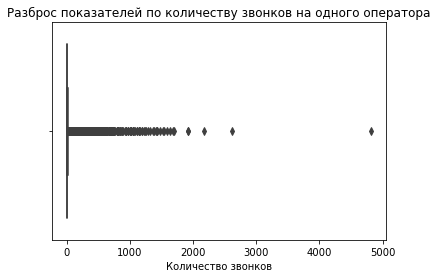

In [15]:
sns.boxplot(data['calls_count'])
plt.title('Разброс показателей по количеству звонков на одного оператора')
plt.xlabel('Количество звонков')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


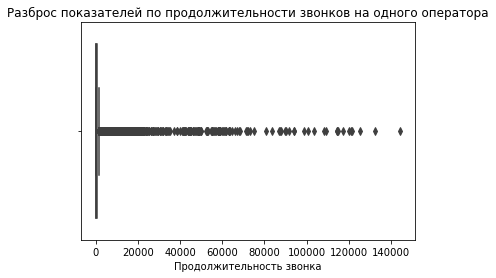

In [16]:
sns.boxplot(data['call_duration'])
plt.title('Разброс показателей по продолжительности звонков на одного оператора')
plt.xlabel('Продолжительность звонка')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


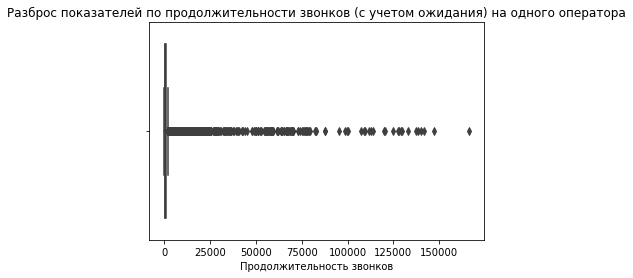

In [17]:
sns.boxplot(data['total_call_duration'])
plt.title('Разброс показателей по продолжительности звонков (с учетом ожидания) на одного оператора')
plt.xlabel('Продолжительность звонков')
plt.show()

Мы видим явные выбросы в данных: 
- 4817 звонков в день
- 144395 секунд (40 часов) в день длительность разговоров 
- 166155 секунд (46 часов) в день длительность разговоров (с учетом времени ожидания)

Удалим данные, которые находятся за пределами нормальных значений (выше 95 перцентиля).

In [18]:
data = data[data['calls_count'] <= data['calls_count'].quantile(0.95)]
data

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,-1,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
48887,168606,2019-11-10,out,True,957922.0,False,1,0,25
48888,168606,2019-11-10,out,True,957922.0,True,1,0,38
48889,168606,2019-11-11,out,True,957922.0,False,2,479,501
48890,168606,2019-11-15,out,True,957922.0,False,4,3130,3190


In [19]:
display(data['calls_count'].describe())
display(data['call_duration'].describe())
data['total_call_duration'].describe()

count    46461.000000
mean         8.508857
std         11.708323
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max         62.000000
Name: calls_count, dtype: float64

count    46461.000000
mean       534.357181
std       1176.811324
min          0.000000
25%          0.000000
50%         36.000000
75%        512.000000
max      26175.000000
Name: call_duration, dtype: float64

count    46461.000000
mean       680.891048
std       1271.710116
min          0.000000
25%         43.000000
50%        181.000000
75%        718.000000
max      26347.000000
Name: total_call_duration, dtype: float64

Данные очищены от выбросов. Теперь у нас количество звонков максимум 36 в день, продолжительность чуть больше 5 часов, а с учетом времени ожидания суммарно ближе к 6 часам. Данные выглядят корректно.

## Проверить, что каждый оператор работает только с одним колл-центром (user_id). Если нет, определить как поступить с такими операторами

In [20]:
data_check = data.pivot_table(index=['operator_id'], values='user_id', aggfunc='nunique').sort_values('user_id').reset_index()
data_check.query('user_id > 1')

,operator_id,user_id
1092,-1,305


У нас нет операторов, которые принадлежат к нескольким колл-центрам. Каждый оператор зарегистрирован только в одном колл-центре.
Исключением являются операторы, по которым в столбце operator_id стоял пропуск.

## Разделить колл-центры на тех, кто преимущественно работает с исходящими звонками клиентам и тех, кто работает на входящий поток (data_out и data_in)

### Сгрупируем данные по user_id и посчитаем direction

In [21]:
data_group = pd.get_dummies(data, columns=['direction'])
data_group

,user_id,date,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,direction_in,direction_out
0,166377,2019-08-04,False,-1,True,2,0,4,1,0
1,166377,2019-08-05,True,880022.0,True,3,0,5,0,1
2,166377,2019-08-05,True,880020.0,True,1,0,1,0,1
3,166377,2019-08-05,True,880020.0,False,1,10,18,0,1
4,166377,2019-08-05,False,880022.0,True,3,0,25,0,1
...,...,...,...,...,...,...,...,...,...,...
48887,168606,2019-11-10,True,957922.0,False,1,0,25,0,1
48888,168606,2019-11-10,True,957922.0,True,1,0,38,0,1
48889,168606,2019-11-11,True,957922.0,False,2,479,501,0,1
48890,168606,2019-11-15,True,957922.0,False,4,3130,3190,0,1


In [22]:
data_group = data_group.groupby('user_id').agg({'direction_in': 'sum', 'direction_out': 'sum'})
data_group

,direction_in,direction_out
user_id,,
166377,110.0,409.0
166391,19.0,1.0
166392,93.0,0.0
166399,20.0,0.0
166405,342.0,575.0
...,...,...
168583,24.0,0.0
168598,22.0,0.0
168601,31.0,38.0


### Для колл-центров, у которых направление (direction) out>in (т.е. количество ихсодящих звонков превышает входящие) определить в data_out. Аналогично для колл-центров, у которых in>out определить их в data_in, т.к. колл-центр для входящих клиентов. Задание выполнить с помощью написания функции

Разделим колл-центры на три категории:
- входящие
- исходящие
- промежуточные (данные по вход. и исх. звонкам отличаются на 30%)

In [23]:
def in_out(row):
    if row['direction_in'] == 0:
        return 'out'
    elif row['direction_out'] == 0:
        return 'in'
    elif 0.7 <= row['direction_out'] / row['direction_in'] <= 1.3: 
        return 'both'
    elif 0.7 <= row['direction_in'] / row['direction_out'] <= 1.3:
        return 'both'
    elif row['direction_in'] > row['direction_out']:
        return 'in'
    elif row['direction_in'] < row['direction_out']:
        return 'out'

In [24]:
data_group['type'] = data_group.apply(in_out, axis=1)
data_group.reset_index(inplace=True)
data_group

,user_id,direction_in,direction_out,type
0,166377,110.0,409.0,out
1,166391,19.0,1.0,in
2,166392,93.0,0.0,in
3,166399,20.0,0.0,in
4,166405,342.0,575.0,out
...,...,...,...,...
302,168583,24.0,0.0,in
303,168598,22.0,0.0,in
304,168601,31.0,38.0,both
305,168603,1.0,6.0,out


In [25]:
# выделим датасет с колл-центрами,работающими на исходящие звонки

data_out = data.merge(data_group, on='user_id')
data_out = data_out.drop(columns={'direction_in', 'direction_out'})
data_out = data_out.query('type == "out"')
data_out

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
0,166377,2019-08-04,in,False,-1,True,2,0,4,out
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,out
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,out
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,out
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,out
...,...,...,...,...,...,...,...,...,...,...
46456,168606,2019-11-10,out,True,957922.0,False,1,0,25,out
46457,168606,2019-11-10,out,True,957922.0,True,1,0,38,out
46458,168606,2019-11-11,out,True,957922.0,False,2,479,501,out
46459,168606,2019-11-15,out,True,957922.0,False,4,3130,3190,out


In [26]:
# выделим датасет с колл-центрами,работающие на входящие звонки

data_in = data.merge(data_group, on='user_id')
data_in = data_in.drop(columns={'direction_in', 'direction_out'})
data_in = data_in.query('type == "in"')
data_in

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
519,166391,2019-08-06,in,False,882476.0,False,1,175,186,in
520,166391,2019-08-06,in,True,-1,True,3,0,163,in
521,166391,2019-08-07,in,True,882478.0,False,2,11,74,in
522,166391,2019-08-07,in,False,882478.0,False,1,57,70,in
523,166391,2019-08-07,out,True,882478.0,True,1,0,7,in
...,...,...,...,...,...,...,...,...,...,...
46369,168598,2019-11-25,in,False,958394.0,False,4,2108,2134,in
46370,168598,2019-11-25,in,False,-1,True,1,0,18,in
46371,168598,2019-11-27,in,False,958394.0,False,2,89,100,in
46372,168598,2019-11-28,in,False,958394.0,False,7,1316,1359,in


In [27]:
# выделим датасет с промужуточными колл-центрами

data_both = data.merge(data_group, on='user_id')
data_both = data_both.drop(columns={'direction_in', 'direction_out'})
data_both = data_both.query('type == "both"')
data_both.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
3508,166503,2019-08-08,out,False,884412.0,False,2,50,66,both
3509,166503,2019-08-08,out,True,884412.0,True,3,0,36,both
3510,166503,2019-08-08,in,True,-1,True,1,0,11,both
3511,166503,2019-08-08,out,False,884412.0,True,1,0,5,both
3512,166503,2019-08-09,in,True,-1,True,5,0,123,both


Посмотрим наглядно распределение типов колл-центров.

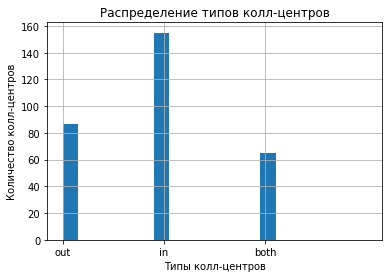

In [28]:
pd.Series(data_group['type']).hist(range = (0, 3), bins=20)
plt.title('Распределение типов колл-центров')
plt.xlabel('Типы колл-центров')
plt.ylabel('Количество колл-центров')
plt.show()

## Посчитаем количество исходящих вызовов в data_out в группировке по операторам; посчитаем среднюю длительность звонка, отсортируем по возрастанию. Построим столбчатую диаграмму по полученым данным

In [29]:
data_out = data_out.query('direction == "out"') # отфильтруем исходящие звонки
data_out

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,out
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,out
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,out
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,out
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,out
...,...,...,...,...,...,...,...,...,...,...
46455,168606,2019-11-09,out,False,957922.0,False,4,551,593,out
46456,168606,2019-11-10,out,True,957922.0,False,1,0,25,out
46457,168606,2019-11-10,out,True,957922.0,True,1,0,38,out
46458,168606,2019-11-11,out,True,957922.0,False,2,479,501,out


Для исходящих звонков у нас есть показатель internal, который принимает значения True и False, что значит соответственно переводился звонок на другого оператора или нет. 

Разделим датасет на два по этому параметру и посмотрим по отдельности.

In [30]:
data_out_true = data_out.query('direction == "out" and internal == True')
data_out_true

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,out
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,out
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,out
11,166377,2019-08-06,out,True,881278.0,True,2,0,5,out
24,166377,2019-08-12,out,True,880028.0,True,1,0,26,out
...,...,...,...,...,...,...,...,...,...,...
46064,168412,2019-11-28,out,True,952468.0,True,11,0,0,out
46456,168606,2019-11-10,out,True,957922.0,False,1,0,25,out
46457,168606,2019-11-10,out,True,957922.0,True,1,0,38,out
46458,168606,2019-11-11,out,True,957922.0,False,2,479,501,out


In [31]:
data_out_false = data_out.query('direction == "out" and internal == False')
data_out_false

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,out
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,out
6,166377,2019-08-05,out,False,880020.0,True,8,0,50,out
9,166377,2019-08-06,out,False,881278.0,True,3,0,29,out
10,166377,2019-08-06,out,False,880020.0,True,5,0,70,out
...,...,...,...,...,...,...,...,...,...,...
46447,168603,2019-11-21,out,False,959118.0,False,5,338,423,out
46448,168603,2019-11-27,out,False,959118.0,False,1,76,99,out
46450,168606,2019-11-08,out,False,957922.0,True,2,0,40,out
46452,168606,2019-11-08,out,False,957922.0,False,2,255,328,out


Посмотрим, сколько в среднем звонков делает каждый оператор, а также, сколько в среднем времени уходит на один звонок.

In [32]:
data_out_true = data_out_true.groupby(['user_id', 'operator_id']).agg({'calls_count': 'mean', 'call_duration': 'mean'}).sort_values('calls_count').reset_index()
data_out_true

,user_id,operator_id,calls_count,call_duration
0,167176,905480.0,1.000000,0.000000
1,167626,919476.0,1.000000,0.000000
2,166997,903312.0,1.000000,12.200000
3,167626,919906.0,1.000000,0.000000
4,166940,897030.0,1.000000,0.000000
...,...,...,...,...
342,166916,906394.0,6.303030,315.045455
343,166843,913868.0,7.000000,0.000000
344,168336,969380.0,7.000000,0.000000
345,168412,952468.0,8.090909,0.000000


Мы определили операторов, у которых в среднем было небольшое количество звонков и продолжительность их в среднем тоже была минимальна. При том, эти операторы еще и переводили звонки на своих коллег. Серьезный повод задуматься об их неэффективности. 

Посмотрим график для наглядности.

In [33]:
data_out_false = data_out_false.groupby(['user_id', 'operator_id']).agg({'calls_count': 'mean', 'call_duration': 'mean'}).sort_values('calls_count').reset_index()
data_out_false.head()

,user_id,operator_id,calls_count,call_duration
0,166377,-1,1.0,0.00
1,167497,918958.0,1.0,0.00
2,166507,883898.0,1.0,70.00
3,167497,-1,1.0,0.00
4,167475,914816.0,1.0,385.75


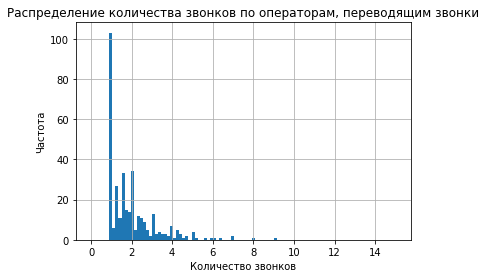

In [34]:
pd.Series(data_out_true['calls_count']).hist(range = (0, 15), bins=100)
plt.title('Распределение количества звонков по операторам, переводящим звонки')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

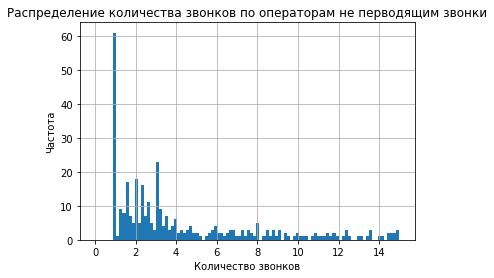

In [35]:
pd.Series(data_out_false['calls_count']).hist(range = (0, 15), bins=100)
plt.title('Распределение количества звонков по операторам не перводящим звонки')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

Чтобы достоверно определить границу эффективности, определим, сколько в среднем вывозов может обработать оператор за рабочую смену (8 часов).

Для расчета данного показателя у нас есть два нужных столбца: calls_count и call_duration. Проверим максимальное значение в столбце с продолжительностью звонка.

In [36]:
data_out['call_duration'].max()

16339

У нас получилось всего 4,6 часов. Маловато. Значит, вероятнее всего нужно перемножить значения двух столбцов calls_count и call_duration.

In [37]:
data_out['full_duration'] = data_out['call_duration'] * data_out['calls_count']

C:\Users\79231\AppData\Local\Temp/ipykernel_11192/1262752519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_out['full_duration'] = data_out['call_duration'] * data_out['calls_count']


Посмотрим, сколько в среднем звонков делает каждый оператор.

In [38]:
data_work = data_out.groupby(['date', 'operator_id']).agg({'calls_count': 'sum', 'full_duration': 'sum'}).reset_index()

# сразу сделаем срез по 8 часовой смене. Однако брать ровно 8 часов сильно "жестко", возьмем промежутов от 7,5 до 8 часов.
#С учетом того, что оператор может делать перерывы между звонками и/или звонки идут не один за другим

data_work = data_work.query('full_duration >= 27000')
data_work = data_work.query('full_duration <= 28800')

Для того, чтобы определить границу эффективности по количеству звонков за смену для каждого оператора, возьмем медианное значение по отобранным данным. Среднее брать не рационально, так как данный показатель может легко смеситься, если кто-то из операторов будет работать чуть усерднее (или наоборот). При медианном же значении такого не будет. 

In [39]:
data_work['calls_count'].median()

27.0

Также посмотрим распределение звонков в день.

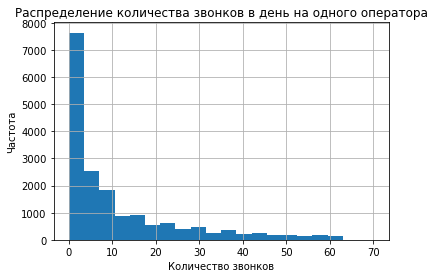

In [40]:
pd.Series(data_out['calls_count']).hist(range = (0, 70), bins=20)
plt.title('Распределение количества звонков в день на одного оператора')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

По нашим данным мы получили число 27. Столько звонков оператор может совершить за рабочую смену. Однако, нельзя говорить, что это граница эффективности. Это скорее показывает норму звонков в день.

При этом, по графику мы видим, что основная часть операторов совершает в пределах 10 звонков в день. Между 27 и 10 достаточно большой разрыв.

Не будем ориентироваться на большинство операторов. Возьмем некоторое промежуточное значение за графницу эффектиновсти. Определим, что операторы, совершающие меньше 19 звонков в день - неэффективные..

In [41]:
data_work_ = data_out.groupby(['date', 'user_id', 'operator_id']).agg({'calls_count': 'sum', 'full_duration': 'sum'}).reset_index()

In [42]:
not_effective = data_work_.query('calls_count < 19')
not_effective = not_effective[['user_id', 'operator_id']]
not_effective.head()

,user_id,operator_id
0,166406,879896.0
1,166406,879898.0
2,166406,880240.0
3,166406,879896.0
4,166406,879898.0


## Определим долю пропущенных вызовов на единицу звонка для каждого оператора

In [43]:
missed = data_out.query('is_missed_call == True') # отфильтурем только пропущенные звонки

Проверим их получше. Убедимся, что если звонок пропущен, то и длительность звонка = 0.

In [44]:
missed.groupby('is_missed_call').agg({'call_duration': 'sum'})

,call_duration
is_missed_call,
True,721


Мы не получили ожидаемые данные. У нас есть строки, где при наличии пропущенного входящего звонка есть некоторая продолжительность. Это не корректно. В дальнейшем исключим эти данные из анализа.

In [45]:
data_out = data_out[~((data_out['is_missed_call'] == True) & (data_out['call_duration'] > 0))]
data_out.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type,full_duration
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,out,0
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,out,0
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,out,10
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,out,0
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,out,6


Теперь, когда обработали не корректные данные, связанные с пропусками, посчитаем долю пропущенных звонков на каждого оператора.

In [46]:
data_out_ = data_out.groupby(['user_id', 'operator_id']).agg({'calls_count': 'sum'}).reset_index() # считаем суммарное кол-во звонков

In [47]:
data_out_miss_ = missed.groupby(['user_id', 'operator_id']).agg({'calls_count': 'sum'}).reset_index() # считаем кол-во пропущуенных

In [48]:
# так как мы всем пропускам operator_id присвоили -1, то у нас будут некорректно отображаться user_id. Исключим их из расчетов

out_miss = data_out_.merge(data_out_miss_, on='operator_id')
out_miss = out_miss.query('operator_id != "-1"')

In [49]:
out_miss['miss_ratio'] = out_miss['calls_count_y'] / out_miss['calls_count_x'] # считаем долю пропусков
out_miss = out_miss[['user_id_x', 'operator_id', 'miss_ratio']].sort_values('miss_ratio', ascending=False)
out_miss.head()

,user_id_x,operator_id,miss_ratio
771,166680,919418.0,1.0
786,166688,890226.0,1.0
972,167580,960674.0,1.0
741,166520,885682.0,1.0
964,167580,937366.0,1.0


У нас есть не малое количество 100% пропусков. Так как мы говорим про исходящие колл-центры, то недозвон до клиента вполне возможен, однако их все равно не должно быть много.

Как возможную границу неэффективности возьмем 50% пропусков. Так как менеджер мог позвонить одному клиенту два раза и дозвониться только во второй раз. 

In [50]:
not_effective_1 = out_miss.query('miss_ratio > 0.5')
not_effective_1 = not_effective_1[['user_id_x', 'operator_id']]
not_effective_1 = not_effective_1.rename(columns={'user_id_x': 'user_id'})
not_effective_1.head()

,user_id,operator_id
771,166680,919418.0
786,166688,890226.0
972,167580,960674.0
741,166520,885682.0
964,167580,937366.0


## На основании п. 5.4-5.5 определим операторов, которые в среднем сделали наименьшее количество звонков среди всех, при этом с большой долей пропусков на единицу звонка

Неэффектиным оператором исходящего звонков будем считать:
- делает меньше 19 звонков в день
- имеет больше 50% пропущенных звонков

In [51]:
# пока не будем объединять датасеты, выведем по отдельности

display(not_effective.head())
display(not_effective_1.head())

,user_id,operator_id
0,166406,879896.0
1,166406,879898.0
2,166406,880240.0
3,166406,879896.0
4,166406,879898.0


,user_id,operator_id
771,166680,919418.0
786,166688,890226.0
972,167580,960674.0
741,166520,885682.0
964,167580,937366.0


## Посчитаем количество пропущенных вызовов в data_in в группировке по операторам, отсортировать по возрастанию. Посчитаем долю пропусков на единицу звонка

Проверим получше пропущенные звонки. Убедимся, что если звонок пропущен, то и длительность звонка = 0.

In [52]:
data_in.query('is_missed_call == True').groupby('is_missed_call').agg({'call_duration': 'sum'})

,call_duration
is_missed_call,
True,1935


Мы не получили ожидаемые данные. У нас есть строки, где при наличии пропущенного входящего звонка есть некоторая продолжительность. Это не корректно. В дальнейшем исключим эти данные из анализа.

In [53]:
data_in = data_in[~((data_in['is_missed_call'] == True) & (data_in['call_duration'] > 0))]
data_in.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
519,166391,2019-08-06,in,False,882476.0,False,1,175,186,in
520,166391,2019-08-06,in,True,-1,True,3,0,163,in
521,166391,2019-08-07,in,True,882478.0,False,2,11,74,in
522,166391,2019-08-07,in,False,882478.0,False,1,57,70,in
523,166391,2019-08-07,out,True,882478.0,True,1,0,7,in


In [54]:
data_in = data_in.query('direction == "in"') # отфильтруем исходящие звонки

In [55]:
data_miss = data_in.query('is_missed_call == True') # отфильтруем только входящие пропущенные звонки
data_miss

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
520,166391,2019-08-06,in,True,-1,True,3,0,163,in
524,166391,2019-08-07,in,False,-1,True,2,0,71,in
525,166391,2019-08-08,in,False,-1,True,1,0,20,in
526,166391,2019-08-09,in,False,-1,True,1,0,33,in
527,166391,2019-08-10,in,True,-1,True,1,0,38,in
...,...,...,...,...,...,...,...,...,...,...
46363,168598,2019-11-17,in,False,-1,True,3,0,46,in
46364,168598,2019-11-18,in,False,-1,True,9,0,112,in
46365,168598,2019-11-19,in,False,-1,True,8,0,79,in
46370,168598,2019-11-25,in,False,-1,True,1,0,18,in


Теперь, когда обработали не корректные данные, связанные с пропусками, посчитаем долю пропущенных звонков на каждого оператора.

In [56]:
data_in_ = data_in.groupby(['user_id', 'operator_id']).agg({'calls_count': 'sum'}).reset_index() # считаем суммарное кол-во звонков

In [57]:
data_in_miss_ = data_miss.groupby(['user_id', 'operator_id']).agg({'calls_count': 'sum'}).reset_index() # считаем кол-во пропущуенных

In [58]:
# так как мы всем пропускам operator_id присвоили -1, то у нас будут некорректно отображаться user_id. Исключим их из расчетов

in_miss = data_in_.merge(data_in_miss_, on='operator_id')
in_miss = in_miss.query('operator_id != "-1"')

In [59]:
in_miss['miss_ratio'] = in_miss['calls_count_y'] / in_miss['calls_count_x'] # считаем долю пропусков
in_miss = in_miss[['user_id_x', 'operator_id', 'miss_ratio']].sort_values('miss_ratio', ascending=False)
in_miss.head()

,user_id_x,operator_id,miss_ratio
23452,168004,934098.0,0.333333
23420,166837,930242.0,0.250000
23435,167162,905300.0,0.240000
23438,167200,905862.0,0.147059
23411,166487,959312.0,0.125000


У нас минимальный показатель 0.33, в целом неплохо. Для нас неважно, перевел он их на другого оператора или звонок сорвался - у таких операторов минимальное количество звонков и высокая доля пропусков, что явно говорит об их неэффективности по данному параметру. 

Так как мы обрабатываем входящюю линию, то пропущенный звонок в данном случае не приемлим. Даже 1 пропущенный звонок в день это много. Допустим, что считается приемлемым 1 пропущенный звонок за три дня.

Исходя из всего вышесказанного возьмем за границу долю в 0.3 и сделаем список всех операторов, у которых доля пропусков выше этого значения.

In [60]:
in_miss = in_miss.query('miss_ratio >= 0.3')
in_miss.head()

,user_id_x,operator_id,miss_ratio
23452,168004,934098.0,0.333333


Добавим этот список к существующим.

In [61]:
not_effective_2 = in_miss[['user_id_x', 'operator_id']]
not_effective_2 = not_effective_2.rename(columns={'user_id_x': 'user_id'})
not_effective_2.head()

,user_id,operator_id
23452,168004,934098.0


## Посчитаем количество входящих вызовов в data_in в группировке по операторам; посчитаем среднюю длительность звонка, отсортируем по возрастанию. Построим столбчатую диаграмму по полученым данным

Для входящих операторов не будем разделять звонки по параметру internal, проверим это позже при необходимости. Сгруппируем сразу данные по операторам и посмотрим данные в среднем.

In [62]:
data_in_group = data_in.groupby(['user_id', 'operator_id']).agg({'calls_count': 'mean', 'call_duration': 'mean', 'total_call_duration': 'mean'}).sort_values('calls_count').reset_index()
data_in_group

,user_id,operator_id,calls_count,call_duration,total_call_duration
0,166975,899906.0,1.000000,626.000000,645.000000
1,167621,918888.0,1.000000,19.000000,28.375000
2,166604,893400.0,1.000000,29.500000,49.000000
3,168303,-1,1.000000,0.000000,10.500000
4,167286,909768.0,1.000000,278.642857,320.642857
...,...,...,...,...,...
403,167521,-1,25.338462,0.000000,757.676923
404,166582,-1,27.808219,0.000000,328.753425
405,167631,-1,29.000000,0.000000,0.000000
406,167599,954086.0,31.000000,277.000000,341.000000


Важный параментр для определения неэффективных входящих операторов - время ожидания. Добавим колонку с "чистым" среднем временем ожидания.

In [63]:
data_in_group['duration_mean'] = data_in_group['total_call_duration'] - data_in_group['call_duration']
data_in_group

,user_id,operator_id,calls_count,call_duration,total_call_duration,duration_mean
0,166975,899906.0,1.000000,626.000000,645.000000,19.000000
1,167621,918888.0,1.000000,19.000000,28.375000,9.375000
2,166604,893400.0,1.000000,29.500000,49.000000,19.500000
3,168303,-1,1.000000,0.000000,10.500000,10.500000
4,167286,909768.0,1.000000,278.642857,320.642857,42.000000
...,...,...,...,...,...,...
403,167521,-1,25.338462,0.000000,757.676923,757.676923
404,166582,-1,27.808219,0.000000,328.753425,328.753425
405,167631,-1,29.000000,0.000000,0.000000,0.000000
406,167599,954086.0,31.000000,277.000000,341.000000,64.000000


Посмотрим наглядно как распределяются данные.

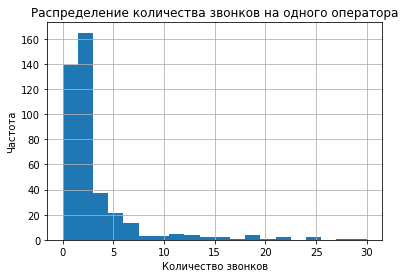

In [64]:
pd.Series(data_in_group['calls_count']).hist(range = (0, 30), bins=20)
plt.title('Распределение количества звонков на одного оператора')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

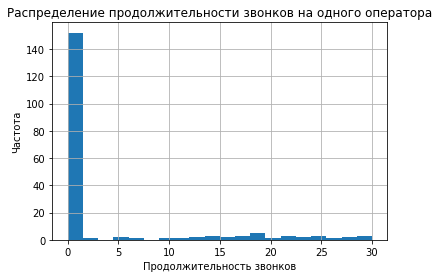

In [65]:
pd.Series(data_in_group['call_duration']).hist(range = (0, 30), bins=20)
plt.title('Распределение продолжительности звонков на одного оператора')
plt.xlabel('Продолжительность звонков')
plt.ylabel('Частота')
plt.show()

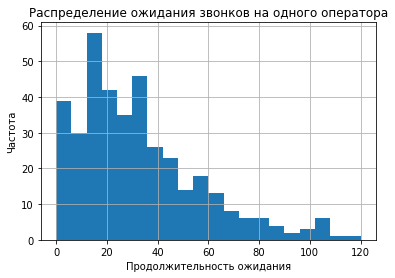

In [66]:
pd.Series(data_in_group['duration_mean']).hist(range = (0, 120), bins=20)
plt.title('Распределение ожидания звонков на одного оператора')
plt.xlabel('Продолжительность ожидания')
plt.ylabel('Частота')
plt.show()

Чтобы достоверно определить границу эффективности, определим, сколько в среднем вывозов может обработать оператор вхоядщей линии за рабочую смену (8 часов).

In [67]:
data_in['full_duration'] = data_in['call_duration'] * data_in['calls_count']

Посмотрим, сколько в среднем звонков делает оператор входящей линии.

In [68]:
data_work_in = data_in.groupby(['date', 'operator_id']).agg({'calls_count': 'sum', 'full_duration': 'sum'}).reset_index()

# сразу сделаем срез по 8 часовой смене. Однако брать ровно 8 часов сильно "жестко", возьмем промежутов от 7,5 до 8 часов.
#С учетом того, что оператор может делать перерывы между звонками и/или звонки идут не один за другим

data_work_in = data_work_in.query('full_duration >= 27000')
data_work_in = data_work_in.query('full_duration <= 28800')

Для того, чтобы определить границу эффективности по количеству звонков за смену для каждого оператора, возьмем медианное значение по отобранным данным. Среднее брать не рационально, так как данный показатель может легко смеситься, если кто-то из операторов будет работать чуть усерднее (или наоборот). При медианном же значении такого не будет.

In [69]:
data_work_in['calls_count'].median()

19.0

Также посмотрим на распределение звонков в день на каждого оператора.

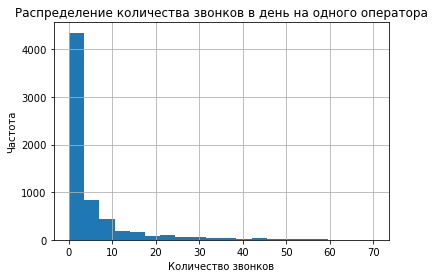

In [70]:
pd.Series(data_in['calls_count']).hist(range = (0, 70), bins=20)
plt.title('Распределение количества звонков в день на одного оператора')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

По нашим данным мы получили число 19. Столько звонков оператор может совершить за рабочую смену. Однако, нельзя говорить, что это граница эффективности. Это скорее показывает норму звонков в день.

При этом, по графику мы видим, что основная часть операторов обрабатывает в пределах 5 звонков в день. Между 19 и 5 достаточно большой разрыв.

Не будем ориентироваться на большинство операторов. Возьмем некоторое промежуточное значение за графницу эффектиновсти. Определим, что входящие операторы, обрабатывающие меньше 12 звонков в день - неэффективные.

In [71]:
data_work_in_ = data_in.groupby(['date', 'user_id', 'operator_id']).agg({'calls_count': 'sum', 'full_duration': 'sum'}).reset_index()

Для того, чтобы определить границу времени ожидания оттолкнемся от данных клиентов, а не от работы операторов (которые могут искусственно изменять границы своей работы). Так, например, определим, когда пользователи в среднем сладут трубку, после какой секунды. 

Для этого отфильтруем данные, когда звонок входящий и пропущенный и посмотрим распределение длительности ожидания.

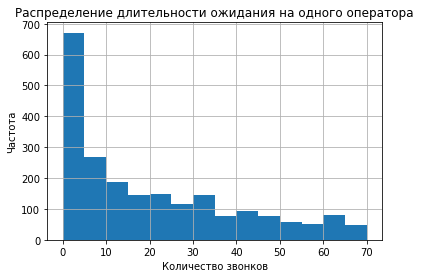

In [72]:
pd.Series(data_miss['total_call_duration']).hist(range = (0, 70), bins=14)
plt.title('Распределение длительности ожидания на одного оператора')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

Мы видим два скачка: один явный, на 5 секундах, второй не сильно явный, но есть - на 35 секундах.

Вероятнее всего данные распределились таким образом потому, что некоторые клиенты кладут трубку почти сразу, не желая ждать. Другая же часть клиентов готова ждать, но не больше 30-35 секунд. После этого значения показатели плавно снижаются и уже не имеют такой большой частоты.

Поэтому, примем за границу неэффективности по показателю ожидания (как границу терпения клиентов) равную 35 секундам.

## На основании п. 5.7-5.8 определим операторов, которые в среднем обработали наименьшее количество звонков среди всех, при этом с большой долей пропусков на единицу звонка и большой долей времени ожидания

Итого для входящих операторов у нас следующие критерии неэффективности:
- количество звонков < 12
- доля пропусков >= 0.3
- ожидание > 35

По пропускам мы уже выше сделали отдельный датасет not_effective_2.

In [73]:
# выведем список таких операторов

not_effective_3 = data_work_in_.query('calls_count < 12')
not_effective_3 = not_effective_3[['user_id', 'operator_id']]
not_effective_3.head()

,user_id,operator_id
0,166392,-1
1,166428,-1
2,166391,-1
3,166391,882476.0
4,166392,-1


Так как, к сожалению, по пропущенным операторам (-1) значения считаются не корретными, исключим их из таблицы.

In [74]:
not_effective_3 = not_effective_3.query('operator_id != "-1"')

In [75]:
not_effective_5 = data_miss.query('total_call_duration > 35') # сделаем список неэффективных операторов по ожиданию
not_effective_5 = not_effective_5[['user_id', 'operator_id']]
not_effective_5 = not_effective_5.query('operator_id != "-1"')
not_effective_5.head()

,user_id,operator_id
2412,166428,882680.0
2510,166482,934076.0
5734,166541,908960.0
5780,166541,908960.0
5786,166541,908960.0


## Посчитаем количество пропущенных вызовов в data_both в группировке по операторам, отсортировать по возрастанию. Посчитаем долю пропусков на единицу звонка

In [76]:
data_both_miss = data_both.query('is_missed_call == True') # отфильтурем только пропущенные звонки

Проверим получше пропущенные звонки. Убедимся, что если звонок пропущен, то и длительность звонка = 0.

In [77]:
data_both_miss.groupby('is_missed_call').agg({'call_duration': 'sum'})

,call_duration
is_missed_call,
True,16028


Мы не получили ожидаемые данные. У нас есть строки, где при наличии пропущенного входящего звонка есть некоторая продолжительность. Это не корректно. В дальнейшем исключим эти данные из анализа.

In [78]:
data_both = data_both[~((data_both['is_missed_call'] == True) & (data_both['call_duration'] > 0))]
data_both.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,type
3508,166503,2019-08-08,out,False,884412.0,False,2,50,66,both
3509,166503,2019-08-08,out,True,884412.0,True,3,0,36,both
3510,166503,2019-08-08,in,True,-1,True,1,0,11,both
3511,166503,2019-08-08,out,False,884412.0,True,1,0,5,both
3512,166503,2019-08-09,in,True,-1,True,5,0,123,both


Посчитаем долю пропущенных звонков для каждого оператора.

Так как мы присваивали значение -1 для всех операторов с NaN, то в дальнейшем объединение пройдет не корректно, поэтому исключим данные из анализа.

In [79]:
data_both = data_both.query('operator_id != "-1"')
data_both_miss = data_both_miss.query('operator_id != "-1"')

In [80]:
data_both_ = data_both.groupby(['user_id', 'operator_id']).agg({'calls_count': 'sum'}).reset_index() # считаем суммарное кол-во звонков

In [81]:
data_both_miss_ = data_both_miss.groupby(['user_id', 'operator_id']).agg({'calls_count': 'sum'}).reset_index() # считаем кол-во пропущуенных

In [82]:
both_miss = data_both_.merge(data_both_miss_, on='operator_id')
both_miss['miss_ratio'] = both_miss['calls_count_y'] / both_miss['calls_count_x'] # считаем долю пропусков
both_miss = both_miss[['user_id_x', 'operator_id', 'miss_ratio']].sort_values('miss_ratio', ascending=False)
both_miss = both_miss.rename(columns={'user_id_x': 'user_id'})
both_miss

,user_id,operator_id,miss_ratio
173,168187,937772.0,1.000000
72,167016,962904.0,1.000000
87,167122,909308.0,1.000000
165,168187,937716.0,1.000000
24,166774,891976.0,1.000000
...,...,...,...
67,166983,909134.0,0.029851
199,168187,937962.0,0.028302
197,168187,937958.0,0.027397
198,168187,937960.0,0.009804


У нас также есть операторы, которые на 100% обработанных звонков сделали 100% пропусков. Несмотря на то, что у нас промежуточный тип колл-центра, это все равно недопустимо.

Посмотрим, каких звонков у нас совершается больше-входящих или исходящих, по эти данным и определим границу-50 или 30%.

In [83]:
data_both['direction'].value_counts()

out    7976
in     4911
Name: direction, dtype: int64

Больше совершается все-таки исходящих звонков. Принимаем операторов, у которых доля пропущенных звонков > 0.5 как неэффективных.

In [84]:
not_effective_6 = both_miss.query('miss_ratio > 0.5')
not_effective_6 = not_effective_6[['user_id', 'operator_id']]
not_effective_6.head()

,user_id,operator_id
173,168187,937772.0
72,167016,962904.0
87,167122,909308.0
165,168187,937716.0
24,166774,891976.0


## Посчитаем количество входящих вызовов в data_both в группировке по операторам; посчитаем среднюю длительность звонка, отсортируем по возрастанию. Построим столбчатую диаграмму по полученым данным

In [85]:
data_both_group = data_both.groupby(['user_id', 'operator_id']).agg({'calls_count': 'mean', 'call_duration': 'mean', 'total_call_duration': 'mean'}).sort_values('calls_count').reset_index()
data_both_group

,user_id,operator_id,calls_count,call_duration,total_call_duration
0,166971,914626.0,1.000000,0.000000,0.000000
1,168187,937772.0,1.000000,0.000000,18.000000
2,168187,937770.0,1.000000,0.000000,37.000000
3,166711,891254.0,1.000000,79.000000,105.000000
4,168187,937720.0,1.000000,9.000000,45.000000
...,...,...,...,...,...
283,168252,940634.0,27.500000,1334.803571,1824.946429
284,168252,940658.0,27.513514,1447.716216,1801.554054
285,168252,961064.0,28.750000,1121.500000,1729.437500
286,166941,896386.0,38.000000,2068.000000,2993.000000


Добавим колонку с "чистым" среднем временем ожидания.

In [86]:
data_both_group['duration_mean'] = data_both_group['total_call_duration'] - data_both_group['call_duration']
data_both_group

,user_id,operator_id,calls_count,call_duration,total_call_duration,duration_mean
0,166971,914626.0,1.000000,0.000000,0.000000,0.000000
1,168187,937772.0,1.000000,0.000000,18.000000,18.000000
2,168187,937770.0,1.000000,0.000000,37.000000,37.000000
3,166711,891254.0,1.000000,79.000000,105.000000,26.000000
4,168187,937720.0,1.000000,9.000000,45.000000,36.000000
...,...,...,...,...,...,...
283,168252,940634.0,27.500000,1334.803571,1824.946429,490.142857
284,168252,940658.0,27.513514,1447.716216,1801.554054,353.837838
285,168252,961064.0,28.750000,1121.500000,1729.437500,607.937500
286,166941,896386.0,38.000000,2068.000000,2993.000000,925.000000


Посмотрим на распределение данных.

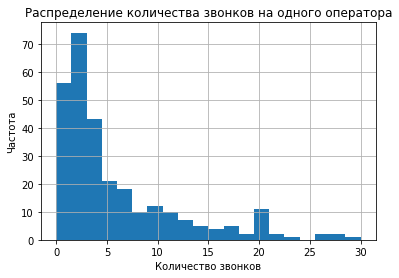

In [87]:
pd.Series(data_both_group['calls_count']).hist(range = (0, 30), bins=20)
plt.title('Распределение количества звонков на одного оператора')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

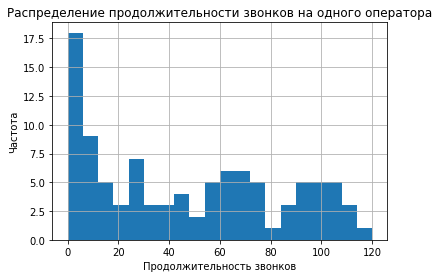

In [88]:
pd.Series(data_both_group['call_duration']).hist(range = (0, 120), bins=20)
plt.title('Распределение продолжительности звонков на одного оператора')
plt.xlabel('Продолжительность звонков')
plt.ylabel('Частота')
plt.show()

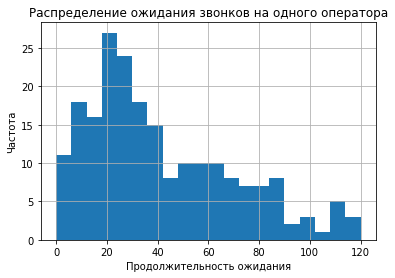

In [89]:
pd.Series(data_both_group['duration_mean']).hist(range = (0, 120), bins=20)
plt.title('Распределение ожидания звонков на одного оператора')
plt.xlabel('Продолжительность ожидания')
plt.ylabel('Частота')
plt.show()

Аналогично входящим и исходящим колл-центрам определим сколько в среднем делает звонков за смену оператор промежуточного типа.

In [90]:
data_both['full_duration'] = data_both['call_duration'] * data_both['calls_count']

In [91]:
data_work_both = data_both.groupby(['date', 'operator_id']).agg({'calls_count': 'sum', 'full_duration': 'sum'}).reset_index()

# сразу сделаем срез по 8 часовой смене. Однако брать ровно 8 часов сильно "жестко", возьмем промежутов от 7,5 до 8 часов.
#С учетом того, что оператор может делать перерывы между звонками и/или звонки идут не один за другим

data_work_both = data_work_both.query('full_duration >= 27000')
data_work_both = data_work_both.query('full_duration <= 28800')

In [92]:
data_work_both['calls_count'].median()

30.5

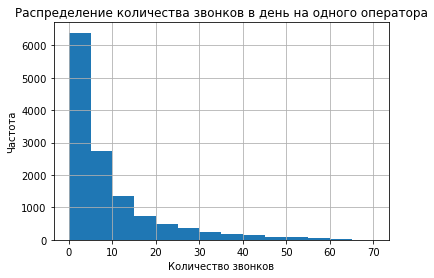

In [93]:
pd.Series(data_both['calls_count']).hist(range = (0, 70), bins=14)
plt.title('Распределение количества звонков в день на одного оператора')
plt.xlabel('Количество звонков')
plt.ylabel('Частота')
plt.show()

По нашим данным мы получили число 30.5 (примем 31). Столько звонков оператор может совершить за рабочую смену. Однако, нельзя говорить, что это граница эффективности. Это скорее показывает норму звонков в день.

При этом, по графику мы видим, что основная часть операторов совершает в пределах 10 звонков в день. Между 31 и 10 достаточно большой разрыв.

Не будем ориентироваться на большинство операторов. Возьмем некоторое промежуточное значение за графницу эффектиновсти. Определим, что операторы, совершающие меньше 21 звонков в день - неэффективные.

In [94]:
data_work_both_ = data_both.groupby(['date', 'user_id', 'operator_id']).agg({'calls_count': 'sum', 'full_duration': 'sum'}).reset_index()

Для промежуточных колл-центров возьмем границу аналогичную как для входящих колл-центров, так как у нас бОльшее число звонков-исходящие. То есть возьмем время ожидания равное 35 секундам как границу неэффективности.

## На основании п. 5.10-5.11 определим операторов, которые в среднем обработали наименьшее количество звонков среди всех, при этом с большой долей пропусков на единицу звонка и большой долей времени ожидания

Итого для промежуточных операторов у нас следующие критерии неэффективности:
- количество звонков <= 21
- доля пропусков > 0.5
- время ожидания >= 35

In [95]:
data_both_ = data_both.groupby(['user_id', 'date', 'operator_id']).agg({'calls_count': 'sum', 'total_call_duration': 'sum'}).reset_index()

In [96]:
# выведем список таких операторов

data_both_ = data_both_[((data_both_['calls_count'] <= 21) & (data_both_['total_call_duration'] >= 35))]
data_both_ = data_both_[['user_id', 'operator_id']]
data_both_ = data_both_.query('operator_id != "-1"')
data_both_

,user_id,operator_id
0,166503,884412.0
1,166503,884408.0
2,166503,884408.0
5,166503,884412.0
9,166503,884412.0
...,...,...
5624,168601,952916.0
5626,168601,952916.0
5628,168601,952914.0
5629,168601,952914.0


In [97]:
not_effective_4 = data_both_[['user_id', 'operator_id']]

По пропускам мы выше вывели список not_effective_6.

## Определить к каким колл-центрам относятся не эффективные операторы

Выведем все таблицы с неэффективными операторами.

In [98]:
display(not_effective.head())
display(not_effective_1.head())
display(not_effective_2.head())
display(not_effective_3.head())
display(not_effective_4.head())
display(not_effective_5.head())
not_effective_6.head()

,user_id,operator_id
0,166406,879896.0
1,166406,879898.0
2,166406,880240.0
3,166406,879896.0
4,166406,879898.0


,user_id,operator_id
771,166680,919418.0
786,166688,890226.0
972,167580,960674.0
741,166520,885682.0
964,167580,937366.0


,user_id,operator_id
23452,168004,934098.0


,user_id,operator_id
3,166391,882476.0
7,166391,882478.0
8,166428,882680.0
10,166428,882680.0
16,166428,882680.0


,user_id,operator_id
0,166503,884412.0
1,166503,884408.0
2,166503,884408.0
5,166503,884412.0
9,166503,884412.0


,user_id,operator_id
2412,166428,882680.0
2510,166482,934076.0
5734,166541,908960.0
5780,166541,908960.0
5786,166541,908960.0


,user_id,operator_id
173,168187,937772.0
72,167016,962904.0
87,167122,909308.0
165,168187,937716.0
24,166774,891976.0


Сделаем одну общую таблицу по всем неэффективным операторам.

In [99]:
final = not_effective.append(not_effective_1)
final = final.append(not_effective_2)
final = final.append(not_effective_3)
final = final.append(not_effective_4)
final = final.append(not_effective_5)
final = final.append(not_effective_6)
final

,user_id,operator_id
0,166406,879896.0
1,166406,879898.0
2,166406,880240.0
3,166406,879896.0
4,166406,879898.0
...,...,...
115,167479,915556.0
189,168187,937870.0
52,166941,896386.0
232,168252,961064.0


In [100]:
final = final.drop_duplicates().reset_index(drop=True) # удалим дубликаты
final

,user_id,operator_id
0,166406,879896.0
1,166406,879898.0
2,166406,880240.0
3,166377,880020.0
4,166377,880022.0
...,...,...
1051,168252,939718.0
1052,167112,933452.0
1053,168187,937898.0
1054,166941,896386.0


In [101]:
final.query('operator_id == "-1"').head()

,user_id,operator_id
21,166658,-1
73,167011,-1
77,167125,-1
115,166997,-1
134,167109,-1


К сожалению, мы достоверно не знаем, являлся ли пропуск=одному сотруднику, поэтому нельзя говорить об эффективности его. Правильнее будет исключить эти данные из окончательных результатов.

In [102]:
final = final.query('operator_id != "-1"')
final

,user_id,operator_id
0,166406,879896.0
1,166406,879898.0
2,166406,880240.0
3,166377,880020.0
4,166377,880022.0
...,...,...
1051,168252,939718.0
1052,167112,933452.0
1053,168187,937898.0
1054,166941,896386.0


In [103]:
final1 = final.groupby('user_id').agg({'operator_id': 'count'}).reset_index().sort_values('operator_id', ascending=False)
final1

,user_id,operator_id
248,168187,50
168,167626,44
255,168252,28
155,167497,28
233,168062,25
...,...,...
177,167664,1
54,166833,1
173,167646,1
170,167634,1


Итого у нас получилось, что 1029 неэффективных оператора приходится на 286 колл-центров. Проверим количество таких операторов от всего числа операторов в каждом колл-центре, где есть неэффективные операторы.

In [104]:
data_ = final.merge(data, on='operator_id')
data_ = data_.query('operator_id != "-1"')
data_ = data_.groupby('user_id_x').agg({'operator_id': 'count'}).reset_index().sort_values('operator_id', ascending=False)
data_ = data_.rename(columns={'user_id_x': 'user_id'})
data_

,user_id,operator_id
248,168187,2265
28,166658,1778
155,167497,1197
66,166916,1115
112,167150,999
...,...,...
109,167139,1
271,168459,1
8,166481,1
236,168090,1


In [105]:
data_ = data_.merge(final1, on='user_id')
data_

,user_id,operator_id_x,operator_id_y
0,168187,2265,50
1,166658,1778,16
2,167497,1197,28
3,166916,1115,16
4,167150,999,6
...,...,...,...
281,167139,1,1
282,168459,1,1
283,166481,1,1
284,168090,1,1


Так как строить график по всем 286 колл-центрам накладно, то посмотрим распределение для первых 10, в которых наибольшее количество неэффективных операторов.

In [106]:
plot = data_.head(10)

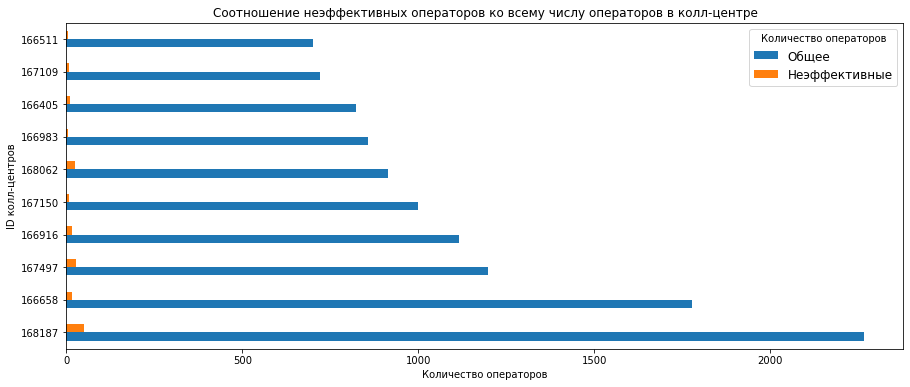

In [107]:
plot.plot(kind='barh', x='user_id', y=['operator_id_x', 'operator_id_y'], figsize=(15,6))
plt.title('Соотношение неэффективных операторов ко всему числу операторов в колл-центре')
plt.xlabel('Количество операторов')
plt.legend(['Общее', 'Неэффективные'], title='Количество операторов', fontsize=12) 
plt.ylabel('ID колл-центров');

На графике мы видим наглядное соотношение всех операторов в колл-центре (синий цвет) к количеству неэффективных операторов (оранжевый). Здесь показаны топ-10 колл-центров с наибольшим числом неэффективных операторов. 

## Определим долю неэффективных операторов в колл-центрах

In [108]:
data_.head()

,user_id,operator_id_x,operator_id_y
0,168187,2265,50
1,166658,1778,16
2,167497,1197,28
3,166916,1115,16
4,167150,999,6


In [109]:
data_['ratio'] = data_['operator_id_y'] / data_['operator_id_x']
#data_ = data_.rename(columns={'operator_id_x': 'total_operators', 'operator_id_y': 'ineffective_operators'})
data_#.sort_values('ratio', ascending=False)

,user_id,operator_id_x,operator_id_y,ratio
0,168187,2265,50,0.022075
1,166658,1778,16,0.008999
2,167497,1197,28,0.023392
3,166916,1115,16,0.014350
4,167150,999,6,0.006006
...,...,...,...,...
281,167139,1,1,1.000000
282,168459,1,1,1.000000
283,166481,1,1,1.000000
284,168090,1,1,1.000000


# Проверка гипотез

1)
- Нулевая(Н0): Доля неэффективных операторов на тарифе С равна доле неэффективных операторов на тарифе В
- Альтернативная(Н1): Доля неэффективных операторов на тарифе В не равна доле неэффективных операторов на тарифе С

Для проверки гипотезы мы выбрали именно тарифы В и С, так как эти тарифы имеет бОльшее количество колл-центров (размер выборки у данных тарифов больше).

In [110]:
#выделим для анализа гипотезы столбец с долями неэффективных операторов в тарифе В и С соответственно

Hip1 = data_.merge(data_clients, on='user_id')
Hip1 = Hip1.rename(columns={'operator_id_x': 'total_operators', 'operator_id_y': 'ineffective_operators'})
Hip1 = Hip1.groupby('tariff_plan').agg({'total_operators': 'sum', 'ineffective_operators': 'sum'}).reset_index()
Hip1

,tariff_plan,total_operators,ineffective_operators
0,A,10410,293
1,B,13728,365
2,C,14218,371


In [111]:
def test(B_not_eff, C_not_eff, B_total, C_total, alpha=.05): 
    p1 = B_not_eff / B_total 
    p2 = C_not_eff / C_total 
    
    difference = p1 - p2
    p_combined = (B_not_eff + C_not_eff) / (B_total+C_total) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / B_total + 1 / C_total))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [112]:
test(Hip1.loc[1][2], Hip1.loc[2][2], Hip1.loc[1][1], Hip1.loc[2][1])

p-значение:  0.796425084930001
Не получилось отвергнуть нулевую гипотезу


2)
- Нулевая(Н0): Доля неэффективных операторов в период с 16-17 ноября 2019 года равна доле неэффективных операторов в период 18-22 ноября 2019 года
- Альбернативная(Н1): Доля неэффективных операторов в период с 16-17 ноября 2019 года не равна доле неэффективных операторов в период 18-22 ноября 2019 года

У нас данные для анализа в период с 02.08.2019 по 28.11.2019. Мы хотим проанализировать различие долей неэффективных операторов в будние дни и в выходные. Для проверки гипотезы взяли временной отрезов ближе к концу периода анализа, так как в это время уже представлено наибольшее число зарегистрированных колл-центров, нежели в начале анализируемого периода (например, август\сентябрь). Опять же из-за размера выборки.

In [113]:
Hip2_16_17_ne = final.merge(data, on='operator_id') # найдем колтичество неэффективных операторов
Hip2_16_17_ne = Hip2_16_17_ne.groupby('date').agg({'operator_id': 'count'}).reset_index()
Hip2_16_17_ne = Hip2_16_17_ne.query('date == "2019-11-16" or date == "2019-11-17"')
Hip2_16_17_ne = Hip2_16_17_ne['operator_id'].sum()
Hip2_16_17_ne

404

In [114]:
Hip2_16_17 = data.groupby('date').agg({'operator_id': 'count'}).reset_index() # найдем общее количество операторов в эти дни
Hip2_16_17 = Hip2_16_17.query('date == "2019-11-16" or date == "2019-11-17"')
Hip2_16_17 = Hip2_16_17['operator_id'].sum()
Hip2_16_17

567

In [115]:
Hip2_18_22_ne = final.merge(data, on='operator_id') # найдем количество неэффективных операторов
Hip2_18_22_ne = Hip2_18_22_ne.groupby('date').agg({'operator_id': 'count'}).reset_index()
Hip2_18_22_ne = Hip2_18_22_ne.query('date == "2019-11-18" or date == "2019-11-19" or date == "2019-11-20" or date == "2019-11-21" or date == "2019-11-22"')
Hip2_18_22_ne = Hip2_18_22_ne['operator_id'].sum()
Hip2_18_22_ne

4361

In [116]:
Hip2_18_22 = data.groupby('date').agg({'operator_id': 'count'}).reset_index() # найдем общее количество операторов в эти дни
Hip2_18_22 = Hip2_18_22.query('date == "2019-11-18" or date == "2019-11-19" or date == "2019-11-20" or date == "2019-11-21" or date == "2019-11-22"')
Hip2_18_22 = Hip2_18_22['operator_id'].sum()
Hip2_18_22

5063

In [117]:
test(Hip2_16_17_ne, Hip2_18_22_ne, Hip2_16_17, Hip2_18_22)

p-значение:  0.0
Отвергаем нулевую гипотезу


Вывод по гипотезам:
- средняя доля неэффективных пользователей в будние дни и в выходные различна, как и ожидалось
- напротив, средние доли в тарифах В и С не сильно отличаются. С вероятностью 20% можно получить одинаковые доли в среднем

# Выводы

## Перечислим колл-центры с долей неэффектиных операторов в них, опишем по каким признакам их определяли

У нас получилось достаточное большое количество колл-центров с неэффектиными операторами.В общем сложности 256 колл-центров. В каждом из них есть от 100% до 0.1% неэффективных операторов от числа всех сотрудников. Есть коллцентры, в которых работает всего 1 оператор, и тот не является эффективным.

Выведем таблицу с такими колл-центрами.

In [118]:
data_.sort_values('ratio', ascending=False)

,user_id,operator_id_x,operator_id_y,ratio
285,166548,1,1,1.000000
277,168366,2,2,1.000000
284,168090,1,1,1.000000
283,166481,1,1,1.000000
282,168459,1,1,1.000000
...,...,...,...,...
60,167235,174,1,0.005747
54,166725,199,1,0.005025
52,166708,205,1,0.004878
50,166833,221,1,0.004525


## Дадим оценку целесообразности разработки автоматизированный системы по определению неэффектиных операторов

Для оценки неэффективности операторов мы использовали различные параметры: например, доля пропущенных звонков, количество входящих\исходящих звонков в среднем, продолжительность ожидания для клиента в среднем. Мы опирались на данные в период от 02.08.2019 по 28.11.2019.

При анализе данных было обнаружено следующее:

Найдено 8172 из 53902 записей, в которых отсутствуют данные об id оператора. Без данного показателя нельзя наверняка сказать, эффективный оператор или нет, так как это единственный показатель, связывающий с конкретным сотрудником. 

В столбце, определяющим был ли звонок внутренним было также обнаружено 117 пропусков. Эти даннные нам пришлось удалить, так как их было < 1% и нельзя было их как-то однозначно заполнить.

Также, были найдены записи о пропущенных звонках, где длительность звонка была больше ноля. Это не корректно. Если вызов пропущен, то длительность звонка должна быть 0. Такие данные нам тоже пришлось исключить, как ошибку при выгрузке данных.

Информацию следует передать тех.специалистам для проверки корректности заполнения данных.

Мы разделили все колл-центры на три категории, чтобы как-то стандартизировать критерии для работы операторов:
- входящие колл-центры (кол-во входящих звонков > кол-ва исходящих)
- исходящие колл-центры (кол-во исходящих звонков > кол-ва входящих)
- промежуточные (разница между кол-вом входящих и исходящих вызовов в пределах 30%)

Для определения эффективности работы операторов для каждого типа колл-центра мы использовали свои критерии:

1) Для оценки работы операторов колл-центров типа входящие 
- число обработанных звонков < 12
- большое время ожидания > 35 
- большое кол-во пропущенных вызовов, доля > 0.3

2) Для оценки работы операторов колл-центров типа исходящие
- небольшое число совершенных вызовов < 19
- большое кол-во пропущенных вызовов, доля > 0.5

3) Для оценки работы операторов колл-центра типа промежуточные
- небольшое число обработанных вызовов < 21
- большое время ожидания > 35
- большое кол-во пропущенных вызовов, доля > 0.5

В итоге по результатам анализа мы получили:

- 1029 неэффективных оператора
- работающих в 286 колл-центрах
- доля неэффектиных операторов в каждом колл-центре имеет разброс от 0.1 до 100%

Такое большое количество неэффективных операторов объясняется большим количеством операторов, совершивших за весь период по 1-2 звонка. 

При проверки статистических гипотез мы воявили, что операторы работают с разной эффективностью в будни и в выходные. Однако, при сравнении средней доли неэффективных операторов в тарифах В и С обнаружили, что с вероятностью 20% можно получить одинаковые доли.

Причинами появления неэффективных операторов может быть:

- специфика работы - возможно, некоторые вопросы клиентов требуют более детальной проработки вопроса, в связи с этим долгое ожидание. В таком случае можно подумать над оптимизацией процессов (например, написание различных инструкций или создание базы данных ответов на вопросы пользователей)

- личные качества сотрудника. Возможно ему действительно сложно по каким-то причинам обрабатывать или совершать звонки и стоит подумать о смене сферы деятельности

Рекомендации:

- добавить всплывающее окно с кратким резюме по итогу разговора (обработан клиент\нет, сорвался звонок, проведена консультация и т.д.). Данное решение сильно упростило бы анализ работы сотрудников, так как было бы понимание итога разговора

- с учетом того, что у нас получилась довольно большая доля неэффективных операторов, можно смело рекомендовать разбработку софта для регулярного анализа эффективности работы сотрудников. Благодаря этому клиенты колл-центра будут обслужены лучшим образом, а сами колл-центры смогут понимать аналитику работы их операторов (для начисления з\п, бонусов\штрафов и т.д.)